# EPC04 
### Nome: Adriel Bombonato Guidini Godinho
### RA: 191011631

## RNA

---

![NN](NN.png)

In [1]:
import numpy as np

class Dataset:

    def create_random_data(self, number_examples=600):
        '''Create random data on uniform distribution 
        
        number_examples    número total de entradas a serem produzidas
        '''
        
        x1 = np.random.uniform(low=0, high=np.pi/2, size=(number_examples,1))
        x2 = np.random.uniform(low=0, high=np.pi/2, size=(number_examples,1))
        x3 = np.random.uniform(low=0, high=np.pi/2, size=(number_examples,1))
        x = np.concatenate((x1, x2, x3), axis=1)

        # Expected results 
        d=1/3*(np.sin(x1)+np.sin(x2)+np.sin(x3))

        # Matrix of all features 
        xd = np.concatenate((x,d), axis=1)

        return xd


    def partition_data(self, number_examples=600, number_test_examples=100):
        '''Data partition with cross validation'''
        
        xd = self.create_random_data(number_examples)
        n_features = xd.shape[0]
        xdt = [] # test matrix

        for i in range(1, number_test_examples+1):
            k = int(np.round((n_features-i)*np.random.rand())) # pick a radom sample from 0 to number_test_examples
            xdt.append(xd[k])
            xd = np.delete(xd, k, 0)
        
        x, d = np.delete(xd, 3, 1), np.delete(xd, [0,1,2], 1)
        xt, dt = np.delete(xdt, 3, 1), np.delete(xdt, [0,1,2], 1)
        
        return x, d, xt, dt 


class RNA:
    def __init__(self, n_neurons=8, learning_decay = False):
        self.n_neurons = n_neurons

        self.w01 = 0 
        self.w02 = 0 
        self.w1 = 0 
        self.w2 = 0

        self.graph_x = [] 
        self.graph_y = [] 

        self.learning_decay = learning_decay

        self.y1 = np.ones((self.n_neurons,1))
    
    #Funções de ativação
    def sigmoid(self, a):
        return 1/(1 + np.exp(-a))
    
    def tanh(self, a):
        return (np.exp(a) - np.exp(-a))/(np.exp(a) + np.exp(-a))

    def relu(self, a):
        return max(0.0, a)

    def leaky_relu(self, a):
        return a if a>0 else 0.01*a
    

    def predict(self, activation_func, x):
        y2_list = []
        for n in range(x.shape[0]):
            for j in range(self.n_neurons):
                self.y1[j] = activation_func((np.dot(x[n],self.w1[j].T) + self.w01[j].T))                                                               
            y2 = activation_func((np.dot(self.y1.T, self.w2) + self.w02))
            y2_list.append(y2[0][0])
        return y2_list
    
    def train(self, x, d, activation_func, error_threshold=0.000001, learning_rate=0.1, decay_rate=0.001, max_epoch=2000):
        epoch = 0
        eqm_ant = 1
        eqm_atual = 0
        nro_padr = x.shape[0]
        nro_entr = x.shape[1]
        self.w2 = np.random.rand(self.n_neurons,1)
        self.w1 = np.random.rand(self.n_neurons,nro_entr)
        self.w02 = np.random.rand()
        self.w01 = np.random.rand(self.n_neurons,1)

        self.graph_x = []
        self.graph_y = []

        while abs(eqm_atual - eqm_ant) > error_threshold and epoch <= max_epoch:
            epoch+=1
            eqm_ant = eqm_atual
            dw2 = 0
            dw1 = np.ones((self.n_neurons,nro_entr))
            dw01 = np.ones((self.n_neurons,1))
            grad_N_escond = np.ones((self.n_neurons,1))
            soma_eq = 0

            for n in range(nro_padr):
                for j in range(self.n_neurons):
                    z = np.dot(x[n],self.w1[j].T) + self.w01[j].T
                    self.y1[j] = activation_func(z[0]) # np.dot --> (nro_padr, nro_entr) x (n_neurons, nro_entr).T --> (nro_padr, n_neurons)
                                                                       # sum --> (nro_padr, n_neurons) + (n_neurons, 1).T
                y2 = activation_func((np.dot(self.y1.T, self.w2)[0][0] + self.w02)) # np.dot --> (n_neurons, 1).T x (n_neurons, 1) --> (1,1)
                                                       # sum --> (1, 1) + (1, 1)
                error = d[n][0] - y2 # sub --> (nro_padr, 1) - (1, 1)
                grad_saida = error * y2 * (1 - y2)
                dw2 = learning_rate * grad_saida * self.y1
                dw02 = learning_rate * grad_saida * (-1)
                self.w2 += dw2 # sum --> (n_neurons, 1) + (n_neurons, 1)
                self.w02 += dw02

                for j in range(self.n_neurons):
                    grad_N_escond[j] = (self.y1[j]) * (1-self.y1[j]) * grad_saida * self.w2[j]
                    dw1[j]= learning_rate * grad_N_escond[j] * x[n] # (1, nro_entr)
                    dw01[j]= learning_rate * grad_N_escond[j] * (-1)                     
                self.w1 += dw1 # sum --> (n_neurons,nro_entr) + (n_neurons, nro_entr)
                self.w01 += dw01

                soma_eq += 0.5*error**2

            eqm_atual = soma_eq/nro_padr
            
            if self.learning_decay:
                learning_rate *= 1/(1 + decay_rate + epoch) 

            self.graph_x.append(epoch)
            self.graph_y.append(eqm_atual)

    def graph_values(self):
        '''Retorna, em uma lista, os valores de X e Y obtidos no treinamento'''
        return self.graph_x, self.graph_y

![Decay](Decay.png)

In [2]:
%%time

Dataset = Dataset()

# Dataset 1 com 500 exemplos e teste em 100
x1, d1, xt1, dt1 = Dataset.partition_data(600, 100)

# Dataset 2 com 600 exemplos e teste em 100
x2, d2, xt2, dt2 = Dataset.partition_data(700, 100)

# Dataset 3 com 700 exemplos e teste em 100
x3, d3, xt3, dt3 = Dataset.partition_data(800, 100)

# Parâmetros para a rede 1
learning_rate = 0.1
decay_rate = 0.001
error_threshold = 0.000001
max_epoch = 2000
n_numbers = 8

RNA1 = RNA(n_numbers, learning_decay=False)

# Treinamento com Dataset 1
RNA1.train(x1, d1, RNA1.tanh, error_threshold, learning_rate, decay_rate, max_epoch)


CPU times: total: 30 s
Wall time: 30.8 s


In [3]:
%%time

# Aumento de neurônios

# Novos Parâmetros para a rede 2
n_numbers2 = 5

RNA2 = RNA(n_numbers2, learning_decay=False)
RNA2.train(x1, d1, RNA1.tanh, error_threshold, learning_rate, decay_rate, max_epoch)

# Novos Parâmetros para a rede 3
n_numbers3 = 10

RNA3 = RNA(n_numbers3, learning_decay=False)
RNA3.train(x1, d1, RNA1.tanh, error_threshold, learning_rate, decay_rate, max_epoch)

C:\Users\adrie\AppData\Local\Temp\ipykernel_13744\350168915.py:64: RuntimeWarning: overflow encountered in exp
  return (np.exp(a) - np.exp(-a))/(np.exp(a) + np.exp(-a))
C:\Users\adrie\AppData\Local\Temp\ipykernel_13744\350168915.py:64: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(a) - np.exp(-a))/(np.exp(a) + np.exp(-a))


CPU times: total: 1min
Wall time: 1min 2s


In [4]:
# Aumento de padrões

# Novos Parâmetros para a rede 4
RNA4 = RNA(n_numbers, learning_decay=False)
RNA4.train(x2, d2, RNA1.tanh, error_threshold, learning_rate, decay_rate, max_epoch)

# Novos Parâmetros para a rede 5
RNA5 = RNA(n_numbers, learning_decay=False)
RNA5.train(x3, d3, RNA1.tanh, error_threshold, learning_rate, decay_rate, max_epoch)

C:\Users\adrie\AppData\Local\Temp\ipykernel_13744\350168915.py:64: RuntimeWarning: overflow encountered in exp
  return (np.exp(a) - np.exp(-a))/(np.exp(a) + np.exp(-a))
C:\Users\adrie\AppData\Local\Temp\ipykernel_13744\350168915.py:64: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(a) - np.exp(-a))/(np.exp(a) + np.exp(-a))


In [5]:
# f para 10 pontos 

results = RNA1.predict(RNA1.tanh, xt1)

arr = np.array(results, ndmin=2)
arr = arr.T

print("        Rede          Valor real             Diferença\n")
for i in range(11):
    print(f'{arr[i][0]} | {dt1[i][0]} | {np.abs(arr[i][0] - dt1[i][0])}')


        Rede          Valor real             Diferença

0.7344702185157967 | 0.8118861307092861 | 0.07741591219348931
0.6565138545718551 | 0.6500418208899401 | 0.006472033681914957
0.8164332174550594 | 0.5248172824593054 | 0.291615934995754
0.631594349497441 | 0.5564260223849324 | 0.07516832711250854
0.7401642809623327 | 0.6868032179921737 | 0.05336106297015897
0.6682493232443549 | 0.7030346137970771 | 0.03478529055272217
0.7281215310922746 | 0.777562922782146 | 0.04944139168987138
0.8738238166954377 | 0.49115740610685316 | 0.3826664105885846
0.7467645655091711 | 0.9530423835307094 | 0.20627781802153822
0.7419561559778004 | 0.6767635681484641 | 0.06519258782933635
0.9999327994161352 | 0.46434787740600797 | 0.5355849220101272


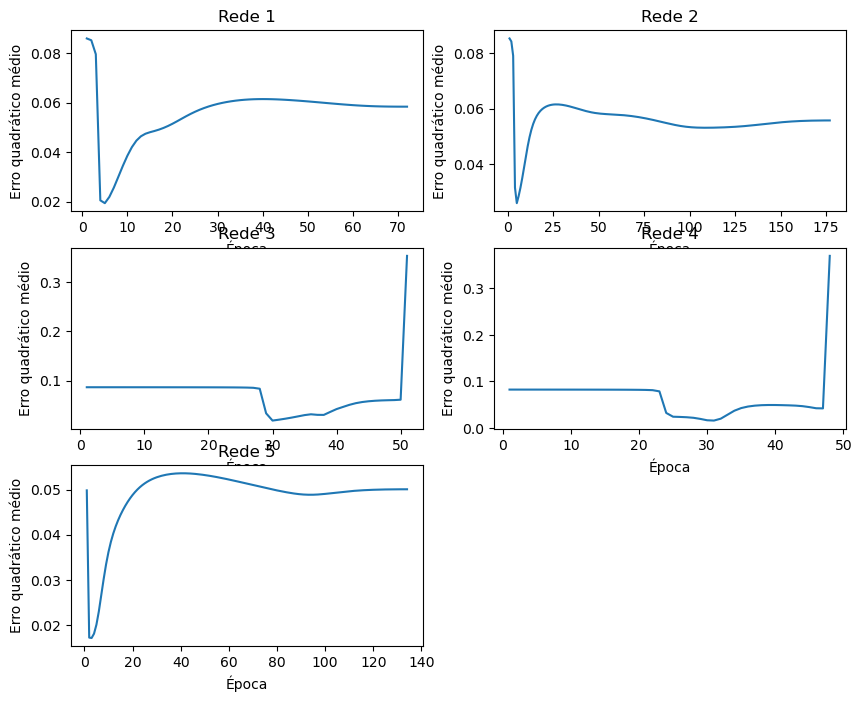

In [6]:
import matplotlib.pyplot as plt

# a) 

x1, y1 = RNA1.graph_values()
x2, y2 = RNA2.graph_values()
x3, y3 = RNA3.graph_values()
x4, y4 = RNA4.graph_values()
x5, y5 = RNA5.graph_values()

# plt.figure()
# plt.xlabel("Época")
# plt.ylabel("Erro quadrático médio")
# plt.title("Comportamento do erro quadrático médio")
# plt.plot(x, y)
# plt.show()

# Plotar todos os resultados
plt.figure(figsize=(10,8))

titles = ['Rede 1', 'Rede 2', 'Rede 3', 'Rede 4', 'Rede 5']
x = [x1, x2, x3, x4, x5]
y = [y1, y2, y3, y4, y5]
for i in range(5):
  plt.subplot(3,2,i+1),plt.plot(x[i], y[i])
  plt.xlabel("Época")
  plt.ylabel("Erro quadrático médio")
  plt.title(titles[i])


plt.show()